In [1]:
CONFIG = '../../logs/vit_sweep/run_288/config.json'
MODEL_PATH = "../../logs/vit_sweep/run_288/best.pth"

In [2]:
import json
import random

from IPython.display import Audio, display
import matplotlib.pyplot as plt
import sys
import os

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

sys.path.append(os.path.abspath('../../'))

with open(CONFIG) as f:
    cfg = json.load(f)

class Config:
    def __init__(self, dictionary):
        for k, v in dictionary.items():
            if isinstance(v, dict):
                setattr(self, k, Config(v))
            else:
                setattr(self, k, v)

cfg = Config(cfg)
cfg.data.root = os.path.join('..', '..', 'data')

In [3]:
from dataset.dataset import SpeechCommandsDataset, get_loader

train_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='training'
)

test_dataset = SpeechCommandsDataset(
    root_dir=cfg.data.root,
    cfg=cfg,
    mode='testing'
)

In [4]:
import torch
from modeling.model import build_model

model = build_model(cfg)

state_dict = torch.load(MODEL_PATH, map_location=torch.device('cpu'))
model.load_state_dict(state_dict)

model.eval()

print("Model loaded successfully!")

/home/andrmd/DeepLearningSpeechRecognition/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model loaded successfully!


In [ ]:
def evaluate_and_display_wrong_predictions(model, test_dataset, n=5):
    model.eval() 
    
    indices = list(range(len(test_dataset)))
    random.shuffle(indices)
    
    wrong_predictions = []
    
    for idx in indices:
        data, true_label = test_dataset[idx]
        
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            output = model(data_tensor)
            probabilities = torch.softmax(output, dim=1)  # Compute softmax probabilities
            predicted_label = torch.argmax(output, dim=1).item()
            prediction_certainty = probabilities[0, predicted_label].item()  # Certainty of the prediction
        
        if predicted_label != true_label:
            wrong_predictions.append((idx, true_label, predicted_label, prediction_certainty))
        
        if len(wrong_predictions) >= n:
            break
    
    for idx, true_label, predicted_label, prediction_certainty in wrong_predictions:
        print(f"Sample Index: {idx}")
        print(f"True Label: {cfg.data.target_commands[true_label]}, Predicted Label: {cfg.data.target_commands[predicted_label]}")
        print(f"Prediction Certainty: {prediction_certainty:.2f}")
        
        waveform, _ = test_dataset.get_waveform(idx)
        display(Audio(waveform, rate=cfg.data.sample_rate))
        print("-" * 50)

In [6]:
evaluate_and_display_wrong_predictions(model, test_dataset, n=10)

Sample Index: 1367
True Label: on, Predicted Label: right


--------------------------------------------------
Sample Index: 2557
True Label: yes, Predicted Label: stop


--------------------------------------------------
Sample Index: 780
True Label: no, Predicted Label: go


--------------------------------------------------
Sample Index: 968
True Label: no, Predicted Label: down


--------------------------------------------------
Sample Index: 172
True Label: down, Predicted Label: stop


--------------------------------------------------
Sample Index: 316
True Label: go, Predicted Label: down


--------------------------------------------------
Sample Index: 570
True Label: left, Predicted Label: right


--------------------------------------------------
Sample Index: 2173
True Label: up, Predicted Label: stop


--------------------------------------------------
Sample Index: 1713
True Label: right, Predicted Label: stop


--------------------------------------------------
Sample Index: 769
True Label: left, Predicted Label: right


--------------------------------------------------


In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

def evaluate_and_plot_confusion_matrix(model, test_dataset):
    model.eval()
    
    true_labels = []
    predicted_labels = []
    
    for idx in range(len(test_dataset)):
        data, true_label = test_dataset[idx]
        data_tensor = torch.tensor(data, dtype=torch.float32).unsqueeze(0)
        
        with torch.no_grad():
            output = model(data_tensor)
            predicted_label = torch.argmax(output, dim=1).item()
        
        true_labels.append(true_label)
        predicted_labels.append(predicted_label)
    
    cm = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=cfg.data.target_commands)
    
    plt.figure(figsize=(10, 10))
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

<Figure size 1000x1000 with 0 Axes>

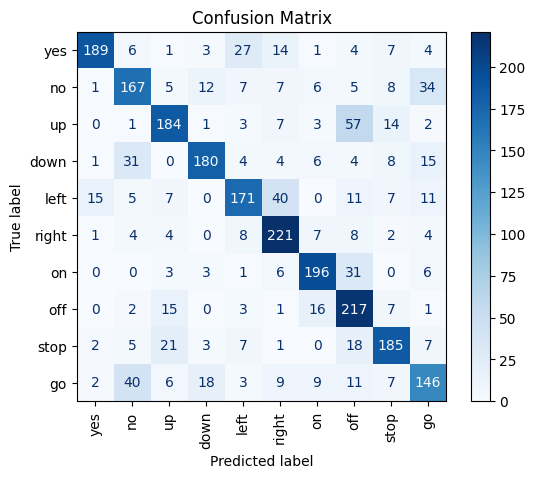

In [8]:
evaluate_and_plot_confusion_matrix(model, test_dataset)